In [55]:
import csv
import pandas as pd
import os
directory = 'D:/jupyter_workspace/wmj'
# paperdat = pd.read_csv("2014acdata.csv")
filename = 'wmj_smiles.csv'
mydat = pd.read_csv(os.path.join(directory,filename))
mydat.head()

,name,ID,CAS,Unnamed: 3,EC50,smiles
0,Tetrabromo bisphenol A,TBBPA,79-94-7,NaN,0.65,CC(C)(C1=CC(=C(C(=C1)Br)O)Br)C2=CC(=C(C(=C2)Br...
1,"Tris(1,3-dichloro-2-propyl)phosphate",TDCPP,13674-87-8,NaN,2.81,C(C(CCl)OP(=O)(OC(CCl)CCl)OC(CCl)CCl)Cl
2,Triphenyl phosphate,TPP,115-86-6,NaN,2.66,C1=CC=C(C=C1)OP(=O)(OC2=CC=CC=C2)OC3=CC=CC=C3
3,Benzyl Butyl Phthalate,BBP,85-68-7,NaN,0.61,CCCCOC(=O)C1=CC=CC=C1C(=O)OCC2=CC=CC=C2
4,Methyl paraben,MP,99-76-3,NaN,2.34,COC(=O)C1=CC=C(C=C1)O


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler


import tensorflow as tf
from keras.layers import Dense, Input, Activation
from keras.layers import BatchNormalization,Add,Dropout
from keras.optimizers import Adam
from keras.models import Model, load_model
from keras import callbacks
from keras import backend as K
from keras.layers.advanced_activations import LeakyReLU
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings(action="ignore",category=DeprecationWarning)
warnings.filterwarnings(action="ignore",category=FutureWarning)
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
%matplotlib inline

In [56]:
#good smiles  check ahead of every mds calculation
smi = mydat['smiles']
goodsmi =[]
for a in smi:
    try:
        b= Chem.CanonSmiles(a)
        goodsmi.append(b)
    except:
        print('Invalid SMILES:',a)
print()

In [131]:
#import rdkit and rdkit chem
from rdkit import Chem
from mordred import Calculator, descriptors
#create descriptor calculator with all descriptors including 3D descriptors，check the smiles are right with a for loop
calc=Calculator(descriptors, ignore_3D=False)
lenofmds = len(calc.descriptors)
print("descriptors number:{:5}".format(lenofmds))
#read smiles list from csv file
mols=[Chem.MolFromSmiles(smi) for smi in mydat['smiles']]
mddf = calc.pandas(mols)
#output the result
# mddf.to_csv("wmjEC50_mds.csv")

descriptors number: 1826


100%|██████████| 40/40 [00:06<00:00,  5.84it/s]


In [145]:
#retain molecular descriptors only contain numeric value for all molecues
print(mddf.shape)
mds2 = mddf.select_dtypes(["number"])
mds2.shape
# mds2['EC50'] = mydat['EC50']
mds2.head()

(40, 1826)


,ABC,ABCGG,nAcid,nBase,nAromAtom,nAromBond,nAtom,nHeavyAtom,nSpiro,nBridgehead,...,SRW09,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb2
0,16.245546,14.372897,0,0,12,12,33,21,0,0,...,0.0,10.170648,55.418626,539.757078,16.356275,876,38,112.0,134.0,4.444444
1,13.593947,13.914364,0,0,0,0,35,20,0,0,...,0.0,9.468001,52.271923,427.883912,12.225255,826,27,86.0,94.0,5.125000
2,17.836588,14.286218,0,0,18,18,38,23,0,0,...,0.0,9.843260,56.915029,326.070796,8.580810,1204,30,116.0,130.0,5.125000
3,17.068022,14.098377,0,0,12,12,43,23,0,0,...,0.0,9.701310,56.405739,312.136159,7.258980,1340,31,108.0,121.0,5.416667
4,7.956514,7.521784,0,0,6,6,19,11,0,0,...,0.0,8.906935,40.567492,152.047344,8.002492,160,13,50.0,55.0,2.611111


In [164]:
#remove any constant in the dataframe
#checking unique values
unique = mds2.nunique().reset_index()
unique.columns = ["colname", "unique_count"]
unique.head(10)
#columns with constant value
constant= unique[unique["unique_count"]==1]
constant.shape
#dropping columns with constant value
mds2.drop(columns= constant['colname'],inplace=True)

In [165]:
mds2['EC50'] = mydat['EC50']

In [153]:
print(mds2)

          ABC      ABCGG  nAcid  nBase  nAromAtom  nAromBond  nAtom  \
0   16.245546  14.372897      0      0         12         12     33   
1   13.593947  13.914364      0      0          0          0     35   
2   17.836588  14.286218      0      0         18         18     38   
3   17.068022  14.098377      0      0         12         12     43   
4    7.956514   7.521784      0      0          6          6     19   
5   10.077834   9.037764      0      0          6          6     28   
6   11.423098   9.416954      0      0          6          6     40   
7    6.542301   6.236096      1      1          6          6     15   
8   17.530641  18.353312      1      0          0          0     24   
9   19.875064  20.681824      1      0          0          0     27   
10  22.219488  22.990790      1      0          0          0     30   
11  23.631953  24.418572      1      0          0          0     32   
12  25.976376  26.700944      1      0          0          0     35   
13  13

In [166]:
correlation = mds2[mds2.columns[:]].corr()['EC50'][:]

In [167]:
correlation = correlation.sort_values(ascending=False)

In [168]:
print('thetop30posfactors: \n', correlation[1:30])
print('thetop30negfactors: \n', correlation[-30:])

thetop30posfactors: 
 nAcid           0.738992
NdO             0.629880
FCSP3           0.627944
HybRatio        0.627944
SlogP_VSA2      0.614462
SdO             0.614028
nBondsD         0.611592
PEOE_VSA2       0.605330
C2SP3           0.598921
ATSC6i          0.591307
nO              0.564629
MATS6i          0.561888
ATSC0se         0.556884
GATS1d          0.540618
TopoPSA         0.540471
FilterItLogS    0.525235
NsssCH          0.524042
ATSC6p          0.519317
TopoPSA(NO)     0.519060
ATSC0pe         0.507884
nG12FRing       0.503410
nG12FARing      0.503410
nFARing         0.503410
nFRing          0.503410
n5ARing         0.503410
n5Ring          0.503410
GGI4            0.501584
VSA_EState2     0.494237
SMR_VSA4        0.494161
Name: EC50, dtype: float64
thetop30negfactors: 
 PEOE_VSA6     -0.580347
piPC8         -0.586180
AATS5p        -0.589575
JGI9          -0.594303
PEOE_VSA10    -0.596081
GATS6p        -0.596555
piPC7         -0.598114
SMR_VSA9      -0.609581
TpiPC10     

In [171]:
#export the result in train data and test data #mds dimension (42,191)
mds2["compound"] = mydat["ID"]
mds2['EC50'] = mydat['EC50']
print(mds2.shape)
#delete the row with log <-1
# dropcol = mds[mds['IE']<-1].index
# mds.drop(dropcol, inplace=True)

# mds.set_index('compound', inplace=True)
print(mds2.head())
print(mds2.shape)

(40, 811)
         ABC      ABCGG  nAcid  nBase  nAromAtom  nAromBond  nAtom  \
0  16.245546  14.372897      0      0         12         12     33   
1  13.593947  13.914364      0      0          0          0     35   
2  17.836588  14.286218      0      0         18         18     38   
3  17.068022  14.098377      0      0         12         12     43   
4   7.956514   7.521784      0      0          6          6     19   

   nHeavyAtom  nHetero  nH  ...     TSRW10          MW        AMW  WPath  \
0          21        6  12  ...  55.418626  539.757078  16.356275    876   
1          20       11  15  ...  52.271923  427.883912  12.225255    826   
2          23        5  15  ...  56.915029  326.070796   8.580810   1204   
3          23        4  20  ...  56.405739  312.136159   7.258980   1340   
4          11        3   8  ...  40.567492  152.047344   8.002492    160   

   WPol  Zagreb1  Zagreb2  mZagreb2  EC50  compound  
0    38    112.0    134.0  4.444444  0.65     TBBPA  
1   

In [172]:
from sklearn.model_selection import train_test_split
Y = mds2['EC50']
# Y = np.log(Y)
X = mds2.drop('EC50', axis=1)
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2, random_state=42)

In [173]:
evaluationdat = pd.DataFrame()
evaluationdat['name'] = X_test['compound']
evaluationdat['EC50'] = Y_test
testID = X_test['compound']
X_train.set_index('compound', inplace=True)
X_test.set_index('compound', inplace=True)
print(X_train.head())
print(Y_train.head())

                ABC      ABCGG  nAcid  nBase  nAromAtom  nAromBond  nAtom  \
compound                                                                    
LCA       21.600841  16.946825      1      0          0          0     67   
4-NP      11.423098   9.416954      0      0          6          6     40   
BP-TMC    18.200457  14.983849      0      0         12         12     49   
PFHpS     19.875064  20.681824      1      0          0          0     27   
BPA       13.141320  11.243837      0      0         12         12     33   

          nHeavyAtom  nHetero  nH  ...     SRW09      SRW10     TSRW10  \
compound                           ...                                   
LCA               27        3  40  ...  7.065613  10.647352  77.578906   
4-NP              16        1  24  ...  0.000000   8.887791  46.439984   
BP-TMC            23        2  26  ...  0.000000  10.313310  58.028285   
PFHpS             26       19   1  ...  0.000000  10.908174  62.622736   
BPA             

In [ ]:
# print(X_train.head())
# print(Y_train.head())
# X_train.to_csv('X_train_wmj.csv')

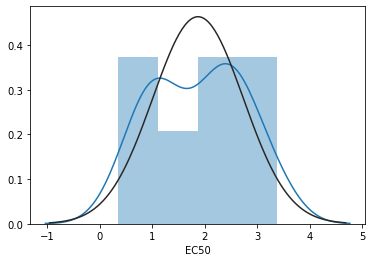

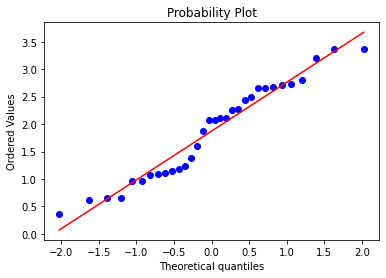

In [62]:
#check the normaality of the dataset
from scipy.stats import norm
import seaborn as sns
from scipy import stats
sns.distplot(Y_train, fit = norm);
fig=plt.figure()
res = stats.probplot(Y_train, plot = plt)

In [63]:
#random forest feature engineering
RF = RandomForestRegressor(random_state=42, n_jobs=-1)
RF.fit(X_train,Y_train)

RandomForestRegressor(n_jobs=-1, random_state=42)

In [64]:
#random forest feature engineering
RF = RandomForestRegressor(random_state=42, n_jobs=-1)
RF.fit(X_train,Y_train)

from pprint import pprint
print('random forest parameters currently in use:\n')
pprint(RF.get_params())

def rmse(actual, pred):
    return np.sqrt(np.mean((actual-pred)**2))

def mse(actual, pred):
    return np.mean((actual-pred)**2)

def r2_score(actual, pred):
    return 1-rmse(actual, pred)/ rmse(actual, np.mean(actual))

def evaluate(model, features, labels):
    predictions = model.predict(features)
    errors = abs(predictions-labels)
    m = 100*(errors/labels)
    accuracy = 100-np.mean(m)
    print('model performance')
    print('average error:{:0.4f}degrees.'.format(np.mean(errors)))
    print('accuracy:',round(accuracy,2),'%.')
    
    return accuracy

# Y_testnp = np.array(Y_test)
# X_testnp = np.array(X_test)
print('valid accuracy')
valid_accuracy = evaluate(RF, X_test, Y_test)

#prediction on random forest
RF_target = RF.predict(X_test)
print(RF_target)
print(Y_test)
print(rmse(RF_target, Y_test))
print(mse(RF_target, Y_test))

random forest parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}
valid accuracy
model performance
average error:0.2813degrees.
accuracy: 75.11 %.
[1.0075 1.1578 1.0648 1.1601 2.584  2.5041 2.1379 0.8551]
19    1.25
16    1.07
15    0.55
26    1.16
4     2.34
12    2.09
37    2.32
27    1.42
Name: EC50, dtype: float64
0.33816071807647896
0.11435267124999987


In [66]:
feature_names = X_train.columns
importances=RF.feature_importances_
featuredata =  pd.DataFrame(importances,feature_names)
featuredata.columns = ['importance']
featuredata = featuredata.sort_values(by=['importance'], ascending = False)
top30 = featuredata[:30]
# top30.head()
# top30.to_csv('IE_DEC26top30_normalreform.csv')

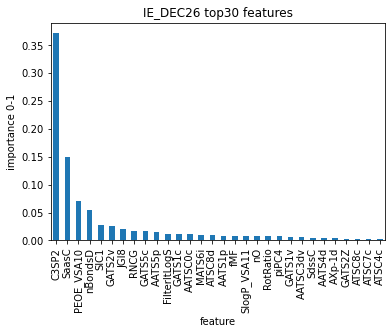

In [67]:
#barplots of all the important features
output_path = 'D:/jupyter_workspace/IE-ANN/resultfigure'
from matplotlib import pyplot as plt
top30['importance'].plot(kind='bar', title='test')
plt.title('IE_DEC26 top30 features')
plt.xlabel('feature')
plt.ylabel('importance 0-1')
outputfig = "IE_DEC26 top30 features_normalreform.jpg"
plt.savefig(os.path.join(output_path,outputfig), dpi=300, 
            quality = 80, optimize = True, progressive = True)

# use features with importances > 0.05 to make linear regression

In [175]:
print(type(X_train))
X_train2 = X_train[['nAcid','NdO','FCSP3','HybRatio','SlogP_VSA2',
 'SdO','nBondsD','PEOE_VSA2','C2SP3','NaasC','C3SP2','nAromAtom',
 'nAromBond','nBondsA','naRing','n6aRing','SMR_VSA7','SlogP_VSA11','nBondsM']]
X_test2 = X_test[['nAcid','NdO','FCSP3','HybRatio','SlogP_VSA2',
 'SdO','nBondsD','PEOE_VSA2','C2SP3','NaasC','C3SP2','nAromAtom',
 'nAromBond','nBondsA','naRing','n6aRing','SMR_VSA7','SlogP_VSA11','nBondsM']]

<class 'mordred._base.pandas_module.MordredDataFrame'>


In [176]:
from sklearn import linear_model
regr = linear_model.LinearRegression()
regr.fit(X_train2,Y_train)
print(regr.intercept_)
print(regr.coef_)

2.7017334185611728
[-0.09778344  2.83221111 -0.90665311 -0.90665311  0.01735861 -0.35698386
  0.28028551  0.12895968  0.07452534 -0.18888347 -0.90418423  0.07151653
  0.07151653  0.07151653  0.01191942  0.01191942 -0.04841668 -0.24445726
  0.35180204]


In [181]:
y = Y_test
regrtarget = regr.predict(X_test2)
print('r2:\n',r2_score(y,regrtarget))

r2:
 -1.537679160780534


Text(1, 2, 'r-squred = -1.537679')

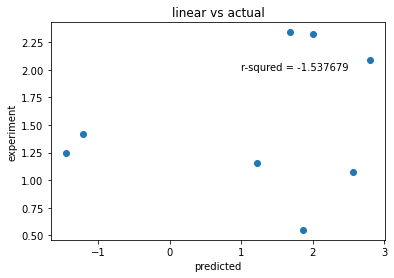

In [178]:
import os
output_path = os.path.abspath('D:/jupyter_workspace/wmj')
#random forest plots
fig,ax2 = plt.subplots()
ax2.scatter(regrtarget,y)
ax2.set_title('linear vs actual')
ax2.set_xlabel('predicted')
ax2.set_ylabel('experiment')
ax2.annotate('r-squred = {:3f}'.format(r2_score(y,regrtarget)),(1,2))

In [ ]:
#notes: try to use the highcorrelated factors defined by corr() to make a linear regression, turns to worse results than the result from 
#rf ranked factors and rf model or linear models

In [179]:
y = Y_test
print(y)

19    1.25
16    1.07
15    0.55
26    1.16
4     2.34
12    2.09
37    2.32
27    1.42
Name: EC50, dtype: float64


Text(1, 2, 'r-squred = 0.447140')

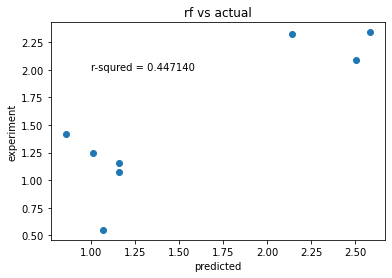

In [74]:
import os
output_path = os.path.abspath('D:/jupyter_workspace/wmj')
#random forest plots
fig,ax2 = plt.subplots()
ax2.scatter(RF_target,y)
ax2.set_title('rf vs actual')
ax2.set_xlabel('predicted')
ax2.set_ylabel('experiment')
ax2.annotate('r-squred = {:3f}'.format(r2_score(y,RF_target)),(1,2))
#ax2.annotate('r-squred = {:3f}'.format(0.68),(1.5,-2))
#ax2.annotate('mse = {:2f}'.format(mse(y, RF_target)),(0,1.7))
#ax2.annotate('rmse= 0.66', )
# outputfig = "simplerf_wmj.jpg"
# plt.savefig(os.path.join(output_path,outputfig), dpi=300, quality = 80, optimize = True, progressive = True)
